Importing all necessary libraries

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import cv2
import glob
import string
from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

Function to import images of needed Training or Test fruits. <br>
Data transformation:  \
&emsp;&emsp;&emsp;&emsp; - Splits each image (100x100x3) into 3 color (100x100) channels; red, green, blue. <br>
&emsp;&emsp;&emsp;&emsp; - Linearizes each color channel (100x100) into a linear array (10,000).

In [114]:
def getFruits(fruits):
    images = []
    labels = []
    r_components = []
    g_components = []
    b_components = []
        
    for i,f in enumerate(fruits):
        fruitFolder_path = "../fruits-360/" + "*" + "/" + f
        j=0
        for image_path in glob.glob(fruitFolder_path + "/*.jpg"):
            image = cv2.imread(image_path)   
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            b , g , r = cv2.split(image)
            images.append(image)
            labels.append(fruits[i])
            r_components.append(r/255)
            g_components.append(g/255)
            b_components.append(b/255)
            j+=1
        print("There are " , j, " images of " , fruits[i].upper())
    images = np.array(images)
    labels = np.array(labels)
    r_components = np.array(r_components)
    g_components = np.array(g_components)
    b_components = np.array(b_components)
    return images, labels, r_components, g_components, b_components

Getting Pineapple training and test sets

In [115]:
images_X, labels_Y, r_components, g_components, b_components = getFruits(["Pineapple", "Onion White"])

There are  656  images of  PINEAPPLE
There are  584  images of  ONION WHITE


Function that grids pictures

In [116]:
def plot_image_grid(images, nb_rows, nb_cols, figsize=(15, 15)):
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    n = 0
    if(nb_rows == 1 or nb_cols ==1):
            for i in range(0,nb_cols+nb_rows-1):
                axs[i].axis('off')
                axs[i].imshow(images[n])
                n += 1
    else:
        for i in range(0, nb_rows):
            for j in range(0, nb_cols):
                axs[i, j].axis('off')
                axs[i, j].imshow(images[n])
                n += 1

Grid of first 100 pictures of pineapples training set

Images of  Pineapple


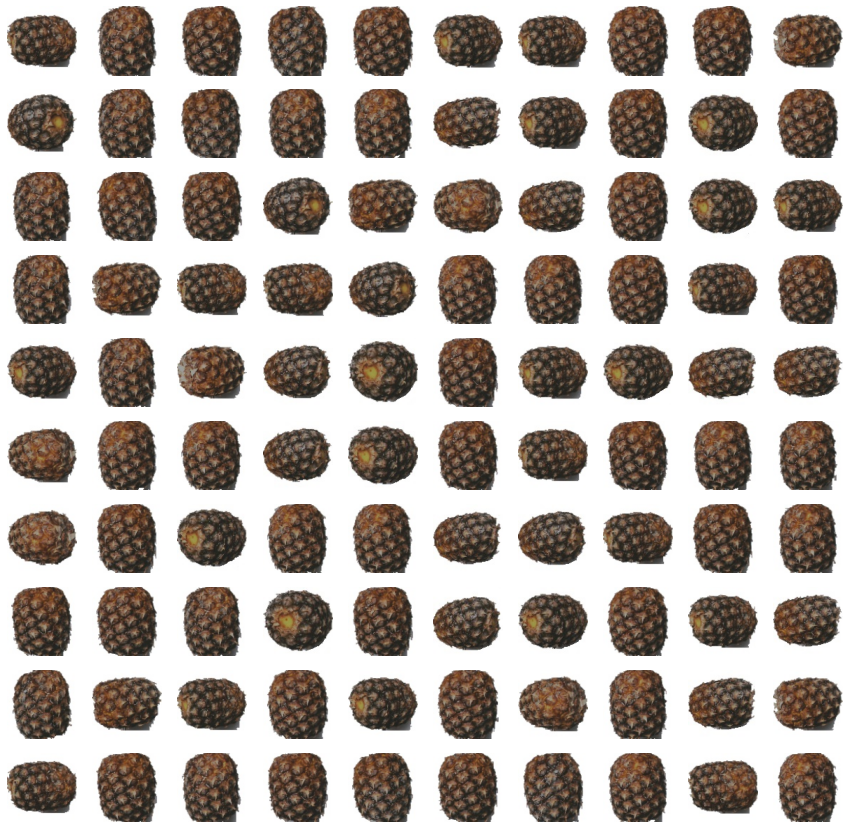

In [117]:
print("Images of ", labels_Y[69])
plot_image_grid(images_X[0:100],10,10)

Function that performs PCA on a single color channel to reduce dimensionality while maintaining highest possible channel quality. <br>
Returns pca_trans which are the n principal components. <br>
Returns pca_projected which are the n principal components projected to 10,000 (100x100) dimensions to be visualized.

In [118]:
def performPCA(n_components, c_components):
    pca = PCA(n_components)
    pca_trans = pca.fit_transform(c_components.reshape(len(c_components),100*100))
    pca_projected = pca.inverse_transform(pca_trans)
    return pca_trans, pca_projected

Perform PCA on all Pineapple training dataset

In [119]:
b_reduced_flat, b_reduced_projected = performPCA(10, b_components) 
g_reduced_flat, g_reduced_projected = performPCA(10, g_components) 
r_reduced_flat, r_reduced_projected = performPCA(10, r_components) 

View sample picture before (left) and after (right) applying PCA.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


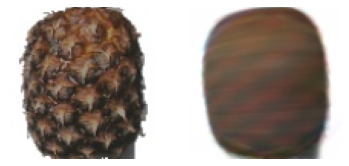

In [120]:
# original image
img1 = cv2.merge((b_components[1].reshape(100,100), g_components[1].reshape(100,100), r_components[1].reshape(100,100)))
# compressed image
img1_compressed = cv2.merge((b_reduced_projected[1].reshape(100,100), g_reduced_projected[1].reshape(100,100), r_reduced_projected[1].reshape(100,100)))

plot_image_grid(np.array([img1,img1_compressed]), 1, 2, (6, 3))

Function that prepare reduced data for training by combining the flattened 3 colors channels into 1 array for each image.

In [121]:
def prepareForTraining(b_reduced_flat,g_reduced_flat,r_reduced_flat):
    
    reduced_flat_imgs = []

    for i in range(0, len(r_reduced_flat)):
        img_flat = np.append(np.append(b_reduced_flat[i],g_reduced_flat[i]),r_reduced_flat[i])
        reduced_flat_imgs.append(img_flat)
    
    reduced_flat_imgs = np.array(reduced_flat_imgs)
    return reduced_flat_imgs

Prepare data for Classification, dividing it into train, tests subsets

In [122]:
X_reduced_flat = prepareForTraining(b_reduced_flat,g_reduced_flat,r_reduced_flat)
x_train, x_test, y_train, y_test = train_test_split(X_reduced_flat,labels_Y,test_size=0.40)

# SVM

Train and Test SVM using splitted training data. <br>
Probability = True, enables 5-fold cross validation.

In [123]:
svm = SVC(kernel="linear", gamma='auto', probability=True)
svm.fit(x_train,y_train)
y_pred=svm.predict(x_test)


Evaluating SVM model

In [124]:
print(f"The model is {metrics.accuracy_score(y_pred,y_test)*100}% accurate")

The model is 100.0% accurate


# KNN

Using 2 nearest neighbours

In [125]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

In [126]:
print(f"The model is {metrics.accuracy_score(y_pred,y_test)*100}% accurate")

The model is 100.0% accurate


Using 10 nearest neighbours

In [127]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print(f"The model is {metrics.accuracy_score(y_pred,y_test)*100}% accurate")

The model is 100.0% accurate


Using 500 nearest neighbours

In [128]:
knn = KNeighborsClassifier(n_neighbors=500)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print(f"The model is {metrics.accuracy_score(y_pred,y_test)*100}% accurate")

The model is 79.23387096774194% accurate


# DECISION TREES

Training decision tree mode; building the tree

In [135]:
tree = DecisionTreeClassifier(max_depth=1)
tree = tree.fit(x_train,y_train)
y_pred = tree.predict(x_test)

Evaluation:

In [136]:
print(f"The model is {metrics.accuracy_score(y_pred,y_test)*100}% accurate")

The model is 100.0% accurate
